# Autoencoders for Collaborative Filtering

In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')

In [3]:
ratings_df = data[['userId', 'movieId', 'rating']]

In [4]:
ratings_df['rating'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4 else 0)


/tmp/ipykernel_11130/1744291944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['rating'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4 else 0)


In [5]:
user_enc = LabelEncoder()
ratings_df['userId'] = user_enc.fit_transform(ratings_df['userId'].values)

item_enc = LabelEncoder()
ratings_df['movieId'] = item_enc.fit_transform(ratings_df['movieId'].values)


/tmp/ipykernel_11130/3728636018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['userId'] = user_enc.fit_transform(ratings_df['userId'].values)
/tmp/ipykernel_11130/3728636018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['movieId'] = item_enc.fit_transform(ratings_df['movieId'].values)


## Split the Data into Train and Test

In [6]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)


## Create Dataloaders

In [7]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings_df, num_users, num_items):
        self.users = ratings_df['userId'].values.astype(np.int64)
        self.items = ratings_df['movieId'].values.astype(np.int64)
        self.ratings = ratings_df['rating'].values.astype(np.float32)

        self.num_users = num_users
        self.num_items = num_items

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]


In [8]:
num_users = ratings_df['userId'].nunique()
num_items = ratings_df['movieId'].nunique()

train_dataset = MovieLensDataset(train_df, num_users, num_items)
test_dataset = MovieLensDataset(test_df, num_users, num_items)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024)


# Create Model Architecture

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, users, items):
        user_emb = self.user_emb(users)
        item_emb = self.item_emb(items)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.sigmoid(x).squeeze()


### Metrics

In [10]:
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)

# Train the Model and Evaluate

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(num_users, num_items, embedding_dim=50, hidden_dim=100).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_losses = []
test_losses = []
maes = []
rmses = []
mses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for users, items, ratings in train_loader:
        users = users.to(device)
        items = items.to(device)
        ratings = ratings.to(device)

        optimizer.zero_grad()
        outputs = model(users, items)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader) # calculate average loss per epoch
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

    model.eval()
    test_loss = 0
    test_mae = 0
    test_rmse = 0
    test_mse = 0

    with torch.no_grad():
        for users, items, ratings in test_loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            outputs = model(users, items)
            loss = criterion(outputs, ratings)

            test_loss += loss.item()
            test_mae += mae(ratings, outputs).item()
            test_rmse += rmse(ratings, outputs).item()
            test_mse += mse(ratings, outputs).item()


        test_loss /= len(test_loader) # calculate average test loss per epoch
        test_losses.append(test_loss)

        test_mae /= len(test_loader) # calculate average mae per epoch
        maes.append(test_mae)

        test_rmse /= len(test_loader) # calculate average rmse per epoch
        rmses.append(test_rmse)

        test_mse /= len(test_loader) # calculate average mse per epoch
        mses.append(test_mse)

    print(f'Test Loss: {test_loss}')
    print(f'Test MAE: {test_mae}')
    print(f'Test RMSE: {test_rmse}')
    print(f'Test MSE: {test_mse}')




Epoch 1/10, Train Loss: 0.6289210734488089
Test Loss: 0.5932237088680268
Test MAE: 0.41090966314077376
Test RMSE: 0.45124675184488294
Test MSE: 0.2036513179540634
Epoch 2/10, Train Loss: 0.5572365726096721
Test Loss: 0.5877001374959946
Test MAE: 0.3762653812766075
Test RMSE: 0.44554654508829117
Test MSE: 0.19854395538568498
Epoch 3/10, Train Loss: 0.516375060700163
Test Loss: 0.58542500436306
Test MAE: 0.3645823135972023
Test RMSE: 0.44379660338163374
Test MSE: 0.19699430838227272
Epoch 4/10, Train Loss: 0.4907975030850761
Test Loss: 0.5836811155080796
Test MAE: 0.379084375500679
Test RMSE: 0.44334964752197265
Test MSE: 0.19659911170601846
Epoch 5/10, Train Loss: 0.464162387802631
Test Loss: 0.6215766936540603
Test MAE: 0.3658381164073944
Test RMSE: 0.45125441551208495
Test MSE: 0.20367684736847877
Epoch 6/10, Train Loss: 0.4341091581537754
Test Loss: 0.6640845656394958
Test MAE: 0.36356947124004363
Test RMSE: 0.46075479686260223
Test MSE: 0.2123781383037567
Epoch 7/10, Train Loss: 0.4

# Visualize the Losses

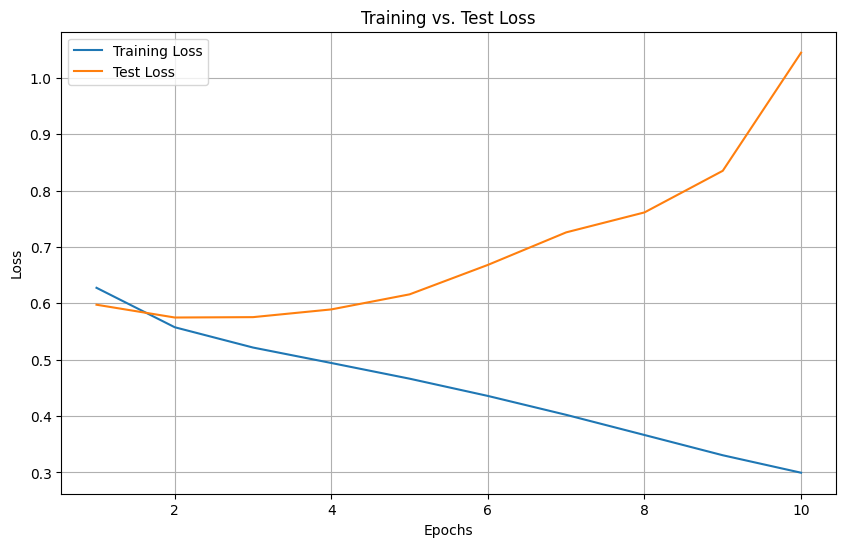

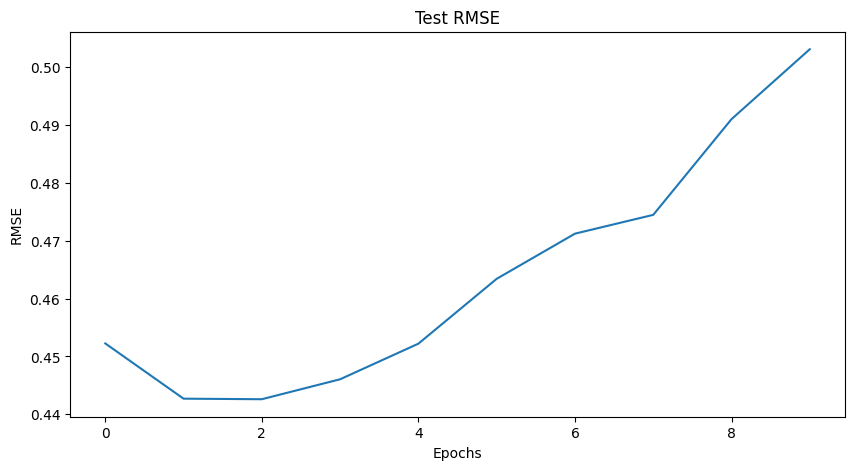

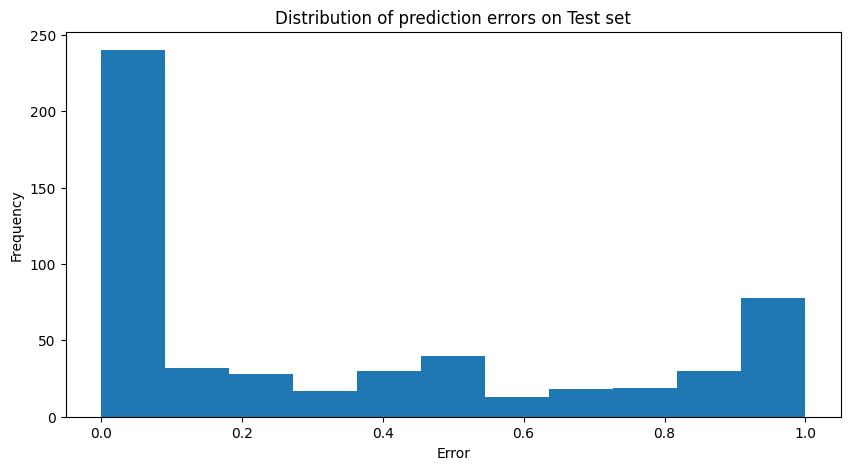

In [12]:
import matplotlib.pyplot as plt

# Plot the losses vs. epochs for training and test sets
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Training vs. Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot the RMSE
plt.figure(figsize=(10,5))
plt.plot(np.arange(num_epochs), rmses)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.show()

# To visualize the distribution of errors on test data
# Assume `errors` as absolute difference between predictions and actual ratings
errors = torch.abs(outputs - ratings).view(-1).cpu().numpy()

plt.figure(figsize=(10,5))
plt.hist(errors, bins='auto')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of prediction errors on Test set')
plt.show()

# Make Recommendations

In [13]:
movies_df = pd.read_csv('../../data/lens_tmdb/cleaned/df_all.csv')

def get_movie_details(movie_id):
    original_id = item_enc.inverse_transform([movie_id])
    movie_row = movies_df[movies_df['movieId'] == original_id[0]]
    movie_name = movie_row['title'].values[0]
    genres = movie_row['genre'].values[0]
    vote_average = movie_row[movie_row['movieId'] == original_id[0]]['vote_average'].values[0]
    return movie_name, genres, vote_average


In [14]:
def recommend(user_id, model, num_items):
    user_ids = torch.tensor([user_id]*num_items).to(device)
    movie_ids = torch.tensor(range(num_items)).to(device)

    with torch.no_grad():
        predictions = model(user_ids, movie_ids)

    _, indices = torch.topk(predictions, 10)
    top_10_movies = indices.cpu().numpy()

    movie_details = [get_movie_details(movie_id) for movie_id in top_10_movies]

    return movie_details


In [15]:
user_id = 42  # Replace with the ID of the user you want to recommend movies to
recommendations = recommend(user_id, model, num_items)
for movie_name, genres, vote_average in recommendations:
    print(f'Movie: {movie_name}')
    print(f'Genres: {genres}')
    print(f'Vote Average: {vote_average}')
    print('\n')


Movie: Rabbit-Proof Fence
Genres: Adventure
Vote Average: 6.9


Movie: The Pawnbroker
Genres: Drama
Vote Average: 7.3


Movie: For the Birds
Genres: Animation
Vote Average: 7.5


Movie: Running on Empty
Genres: Drama
Vote Average: 7.4


Movie: The History Boys
Genres: Comedy
Vote Average: 6.6


Movie: Planet Terror
Genres: Horror
Vote Average: 6.5


Movie: The Corporation
Genres: Documentary
Vote Average: 7.6


Movie: Red Beard
Genres: Drama
Vote Average: 8.1


Movie: Chopper
Genres: Crime
Vote Average: 6.7


Movie: The Man Without a Past
Genres: Romance
Vote Average: 7.0




In [16]:
torch.save(model.state_dict(), '../../data/models/model_weights.pth')